In [1]:
# !pip install darts

In [2]:
# !pip install prophet

In [3]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import darts
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller

Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv("T10Y2Y.csv", names=["ds", "y"], skiprows=1) # prophet вимагає стандартних назв колонок для дати та таргета. 
df


,ds,y
0,2019-12-31,0.34
1,2020-01-01,NaN
2,2020-01-02,0.30
3,2020-01-03,0.27
4,2020-01-06,0.27
...,...,...
1301,2024-12-25,NaN
1302,2024-12-26,0.28
1303,2024-12-27,0.31
1304,2024-12-30,0.31


In [5]:
df["y"] = df["y"].astype("float16")
df["y"]

0       0.340088
1            NaN
2       0.300049
3       0.270020
4       0.270020
          ...   
1301         NaN
1302    0.280029
1303    0.310059
1304    0.310059
1305    0.330078
Name: y, Length: 1306, dtype: float16

In [6]:
# одразу бачимо що у нас є значення NaN. Prophet сам обробить відсутні значення, в колонці зі значеннями. Тож обробляти їх непотрібно.
# Але він очікує що в датах пропусків не буде. Тож перевіримо дати на пропуски

df["ds"].isna().sum() # бачимо, що в колонці з датами пропуски відсутні.

0

In [7]:
# запевнимось, що послідовність дат є неперервною (відсутні пропуски в датах). Насправді ми вже знаємо, що вони є, так як на графіку
all_dates = pd.date_range(start=df["ds"].min(), end=df["ds"].max(), freq="D")
all_dates
# так, як бачимо, в датафреймі у нас 1306 рядків, в all_dates 1828

DatetimeIndex(['2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
               '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=1828, freq='D')

In [8]:
df_all_dates = df.set_index("ds").reindex(all_dates) # встановимо колонку ds як індекс і змінимо індекси на нашу послідовніть all_dates

df_all_dates.index.name = "ds" # повертаємо назву колонки
df_all_dates = df_all_dates.reset_index() # скидаємо індексацію

print(df_all_dates)  # бачимо, що ми втратили значення колонки у

             ds   y
0    2019-12-31 NaN
1    2020-01-01 NaN
2    2020-01-02 NaN
3    2020-01-03 NaN
4    2020-01-04 NaN
...         ...  ..
1823 2024-12-27 NaN
1824 2024-12-28 NaN
1825 2024-12-29 NaN
1826 2024-12-30 NaN
1827 2024-12-31 NaN

[1828 rows x 2 columns]


In [9]:
print(df["ds"][1] == all_dates[1]) # перевіримо, чи еквівалентні дати в датафреймі, датам в all_dates

False


In [10]:
for i in (df["ds"][1], all_dates[1]):
    print(f"val: {i}, type: {type(i)}")

# бачимо типи та значення не співпадають, відповідно у нас не виходить провести реіндексацію так, щоб зберегти відповідні значення колонки y

val: 2020-01-01, type: <class 'str'>
val: 2020-01-01 00:00:00, type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [11]:
df["ds"] = pd.to_datetime(df["ds"])  # переведемо ds із рядка в дату
df["ds"][1]

Timestamp('2020-01-01 00:00:00')

In [12]:
df["ds"][1] == all_dates[1]

True

In [13]:
df_all_dates = df.copy()
df_all_dates = df_all_dates.set_index("ds").reindex(all_dates)

df_all_dates.index.name = "ds"
df_all_dates = df_all_dates.reset_index()

print(df_all_dates) # і отримуємо датафрейм з безперервною послідовнісю дат

             ds         y
0    2019-12-31  0.340088
1    2020-01-01       NaN
2    2020-01-02  0.300049
3    2020-01-03  0.270020
4    2020-01-04       NaN
...         ...       ...
1823 2024-12-27  0.310059
1824 2024-12-28       NaN
1825 2024-12-29       NaN
1826 2024-12-30  0.310059
1827 2024-12-31  0.330078

[1828 rows x 2 columns]


In [14]:
# df_all_dates["y"] = df_all_dates["y"].interpolate(method="linear")
# df_all_dates["y"].isna().sum()  # замінюємо пропуски лінійною інтерполяцією


# UPD: подивившись уважніше на дати, розуміємо що вони відносяться до свят. 
# Тож вірним рішенням у нашому випадку буде не замінювати данні лінійною інтерполяцією, а встановити значення як 0

# df_all_dates["y"] = df_all_dates["y"].fillna(0)
# df_all_dates["y"].isna().sum()

# UPD: так як мит маємо стправу не з продажами то кращє повернути інтерполяцію
df_all_dates["y"] = df_all_dates["y"].interpolate(method="linear")
df_all_dates["y"].isna().sum()  # замінюємо пропуски лінійною інтерполяцією


0

In [15]:
df

,ds,y
0,2019-12-31,0.340088
1,2020-01-01,NaN
2,2020-01-02,0.300049
3,2020-01-03,0.270020
4,2020-01-06,0.270020
...,...,...
1301,2024-12-25,NaN
1302,2024-12-26,0.280029
1303,2024-12-27,0.310059
1304,2024-12-30,0.310059


In [16]:
def plot_df(df, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    cols = df.columns
    print(cols)
    plt.plot(df[cols[0]], df[cols[1]])
    plt.xlabel("date")
    plt.ylabel("value")
    plt.grid()


Index(['ds', 'y'], dtype='object')


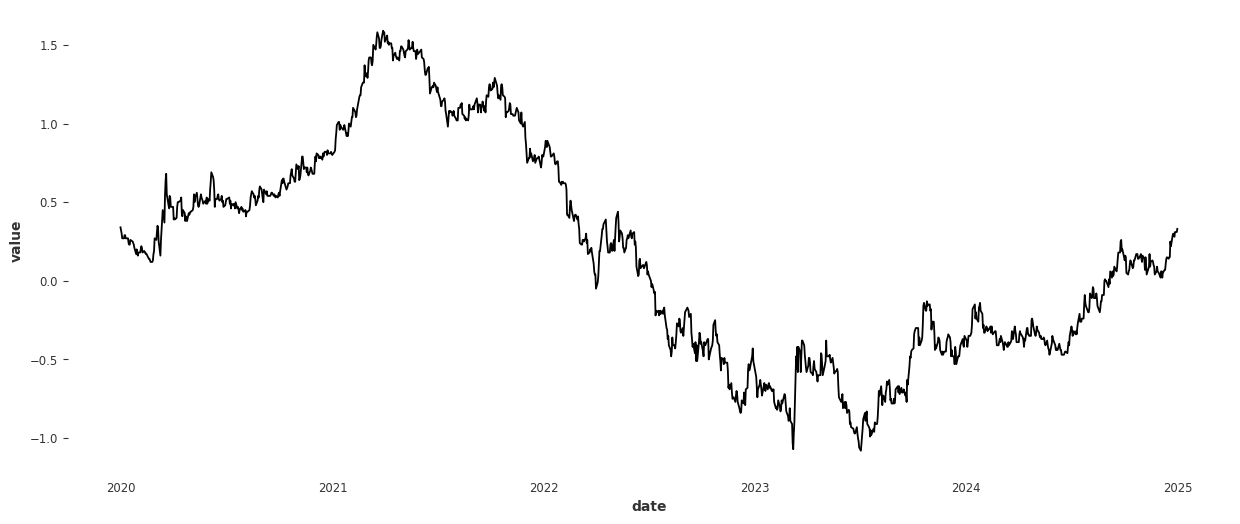

In [17]:
plot_df(df_all_dates) # нормально вони там не працють

In [18]:
def visualise_forecast(model, forecast, test=None, figsize=(15, 6)):
    plt.figure(figsize=figsize)

    fig = model.plot(forecast, figsize=figsize)
    ax = fig.gca()  # Отримання осі графіка

    if test is not None:
        ax.plot(test["ds"], test["y"], "r-", label="test", linewidth=2)

    ax.legend()
    plt.grid(True)
    plt.show()


In [19]:
def visualise_forecast_components(model, forecast, figsize=(15, 10)):
    plt.figure(figsize=(figsize))
    model.plot_components(forecast)
    plt.show()

In [20]:
period = 365

In [21]:
train = df_all_dates[:-period]
test = df_all_dates[-period:]

In [22]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = model.make_future_dataframe(periods=period, freq="D") # створюємо датафрейм для прогнозування. Додаються тільки дати, колонка y залишається пустою. 
                                                #Якщо використовуємо додаткові фічі - їх потрібно додати самостійно 
forecast = model.predict(future)

In [24]:
print(train.tail(), future.head())

             ds         y
1458 2023-12-28 -0.419922
1459 2023-12-29 -0.350098
1460 2023-12-30 -0.357422
1461 2023-12-31 -0.364990
1462 2024-01-01 -0.372559           ds
0 2019-12-31
1 2020-01-01
2 2020-01-02
3 2020-01-03
4 2020-01-04


<Figure size 1500x600 with 0 Axes>

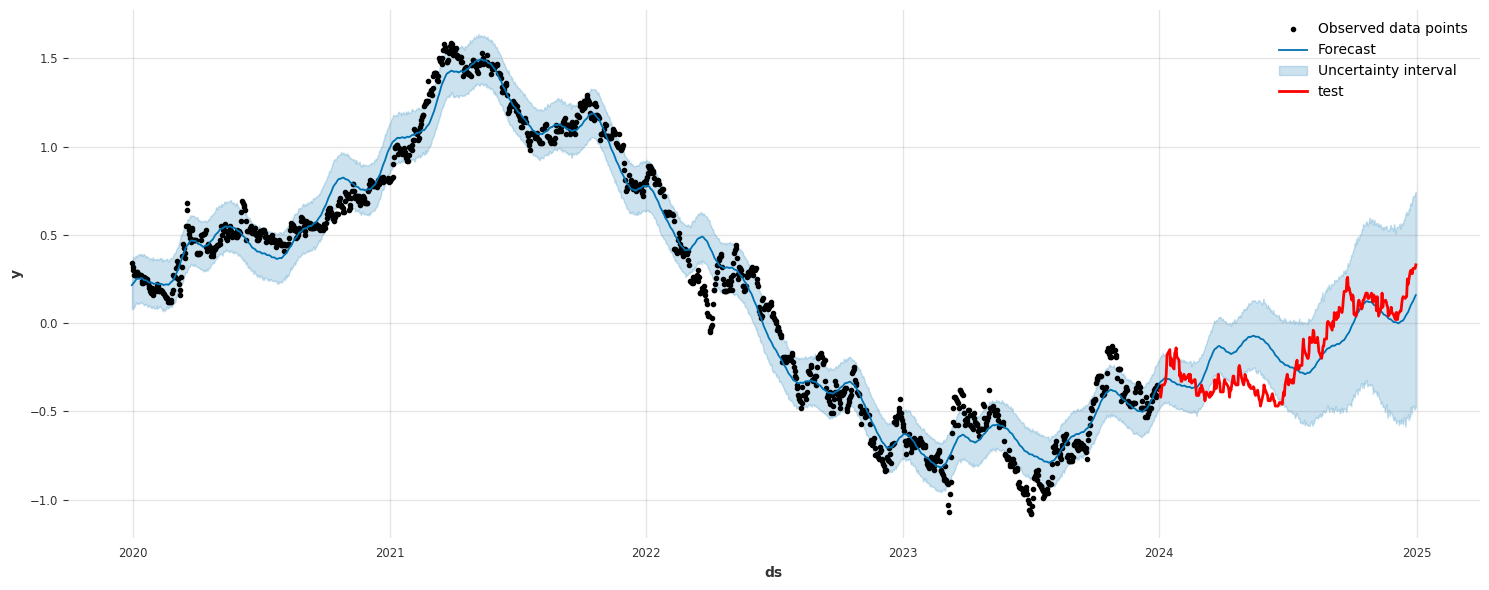

In [25]:
visualise_forecast(model, forecast, test)

In [26]:
# цікаво: явно бачимо, що довжина форкаста менша за довжину period, хоча їх значення рівні

# UPD: потрібно було додати пропущєні дати

# UPD: після зміни підходу до пропущєних даних, "пілообразний" форкаст зник, але появиться коли ми додамо додаковий регресор нижче. Також значно покращилась точність форкаста

<Figure size 1500x1000 with 0 Axes>

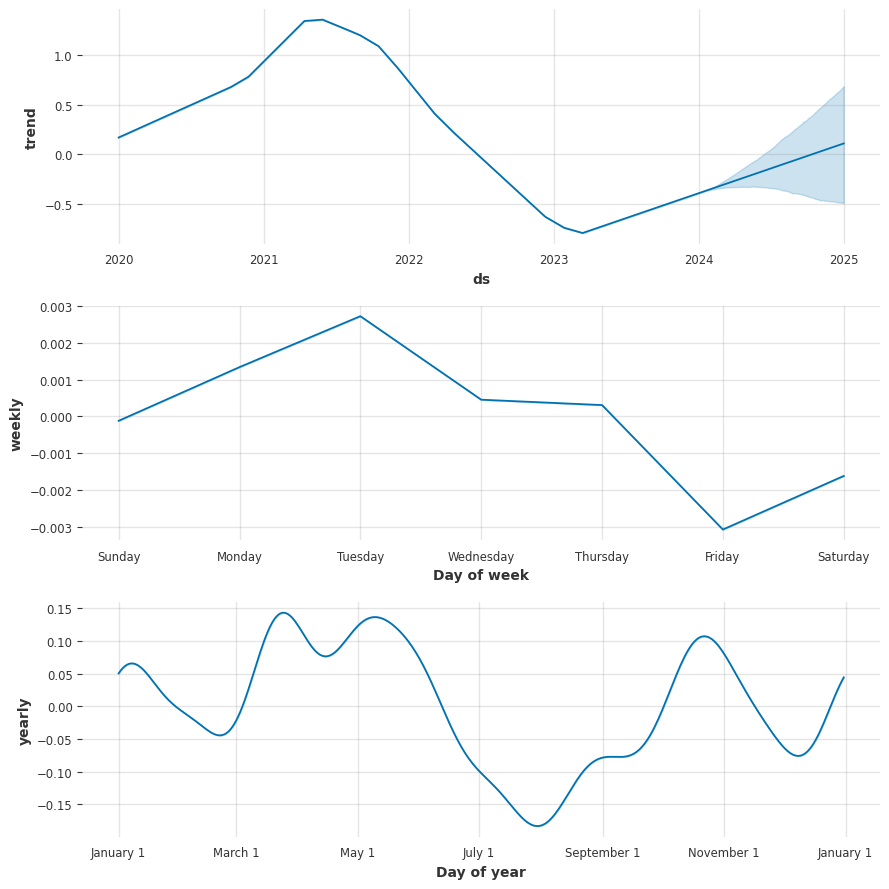

In [27]:
visualise_forecast_components(model, forecast)

In [28]:
# спробуємо додати додактову інформацію про вихідні дні. Поки що шляхом додаткового регресора

df_with_holidays = df.copy()
df_with_holidays

,ds,y
0,2019-12-31,0.340088
1,2020-01-01,NaN
2,2020-01-02,0.300049
3,2020-01-03,0.270020
4,2020-01-06,0.270020
...,...,...
1301,2024-12-25,NaN
1302,2024-12-26,0.280029
1303,2024-12-27,0.310059
1304,2024-12-30,0.310059


In [29]:
df_with_holidays = df_with_holidays.set_index("ds").reindex(all_dates)

df_with_holidays.index.name = "ds"
df_with_holidays = df_with_holidays.reset_index()

print(df_with_holidays)

             ds         y
0    2019-12-31  0.340088
1    2020-01-01       NaN
2    2020-01-02  0.300049
3    2020-01-03  0.270020
4    2020-01-04       NaN
...         ...       ...
1823 2024-12-27  0.310059
1824 2024-12-28       NaN
1825 2024-12-29       NaN
1826 2024-12-30  0.310059
1827 2024-12-31  0.330078

[1828 rows x 2 columns]


In [30]:
df_with_holidays["is_holiday"] = df_with_holidays["y"].isna().astype("Int16")


df_all_dates["y"] = df_all_dates["y"].interpolate(method="linear")
df_with_holidays

,ds,y,is_holiday
0,2019-12-31,0.340088,0
1,2020-01-01,NaN,1
2,2020-01-02,0.300049,0
3,2020-01-03,0.270020,0
4,2020-01-04,NaN,1
...,...,...,...
1823,2024-12-27,0.310059,0
1824,2024-12-28,NaN,1
1825,2024-12-29,NaN,1
1826,2024-12-30,0.310059,0


In [31]:
train, test = df_with_holidays[: -period], df_with_holidays[-period: ]

In [32]:
test

,ds,y,is_holiday
1463,2024-01-02,-0.379883,0
1464,2024-01-03,-0.419922,0
1465,2024-01-04,-0.389893,0
1466,2024-01-05,-0.350098,0
1467,2024-01-06,NaN,1
...,...,...,...
1823,2024-12-27,0.310059,0
1824,2024-12-28,NaN,1
1825,2024-12-29,NaN,1
1826,2024-12-30,0.310059,0


In [33]:
model = Prophet()
model.add_regressor("is_holiday")
model.fit(train)


17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = model.make_future_dataframe(periods=period, freq="D")
future["is_holiday"] = future["ds"].isin(test["ds"]).astype(int)
future

,ds,is_holiday
0,2019-12-31,0
1,2020-01-01,0
2,2020-01-02,0
3,2020-01-03,0
4,2020-01-04,0
...,...,...
1823,2024-12-27,1
1824,2024-12-28,1
1825,2024-12-29,1
1826,2024-12-30,1


In [35]:
future["is_holiday"].sum()

365

In [36]:
print(future.dtypes)

ds            datetime64[ns]
is_holiday             int64
dtype: object


In [37]:
forecast = model.predict(future)

<Figure size 1500x600 with 0 Axes>

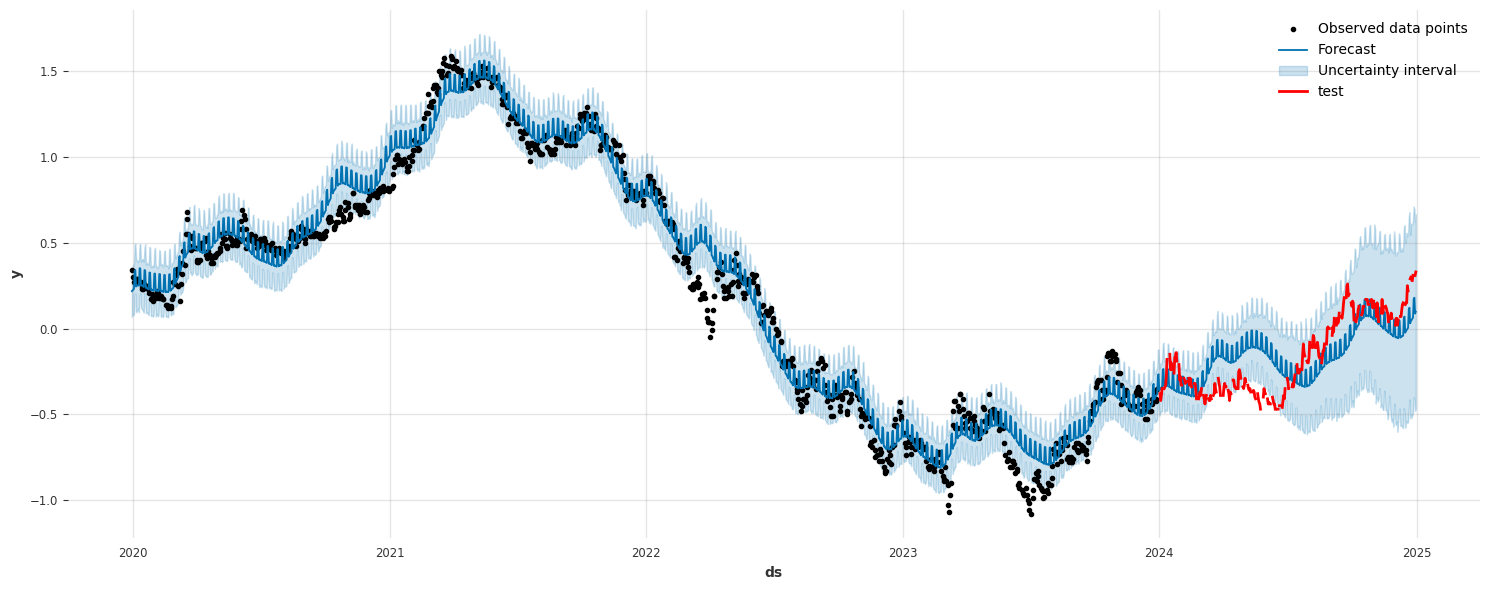

In [38]:
visualise_forecast(model, forecast, test)

In [39]:
# наш форкаст став менш пилообразним, що свідчить про те, що регресор is_holiday вніс більше додаткової інформації в модель


Уважно почитав з якими саме даними ми маємо справу. Це - динаміка процентних ставок між 10 річними та 2 річними облігаціями. Тож нам потрібні додаткові регресори такі як: динаміка ключової ставки, інфляція, геополітична обстановка, тощо. Нажаль я не зміг скачати такі дані, щоб додати їх у якості регресорів для моделі.

# Darts

In [40]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mse, mae

In [41]:
series = TimeSeries.from_dataframe(df_all_dates, "ds", "y") 
series

<TimeSeries (DataArray) (ds: 1828, component: 1, sample: 1)> Size: 15kB
array([[[0.34008789]],

       [[0.32006836]],

       [[0.30004883]],

       ...,

       [[0.31005859]],

       [[0.31005859]],

       [[0.33007812]]])
Coordinates:
  * ds         (ds) datetime64[ns] 15kB 2019-12-31 2020-01-01 ... 2024-12-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='ds'>

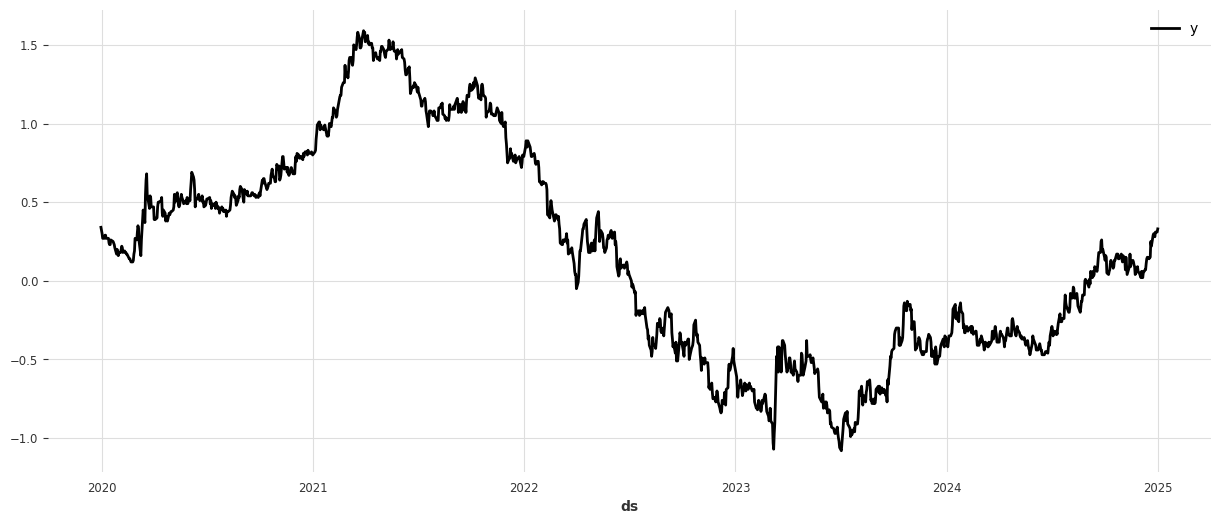

In [42]:
plt.figure(figsize=(15, 6))
series.plot()

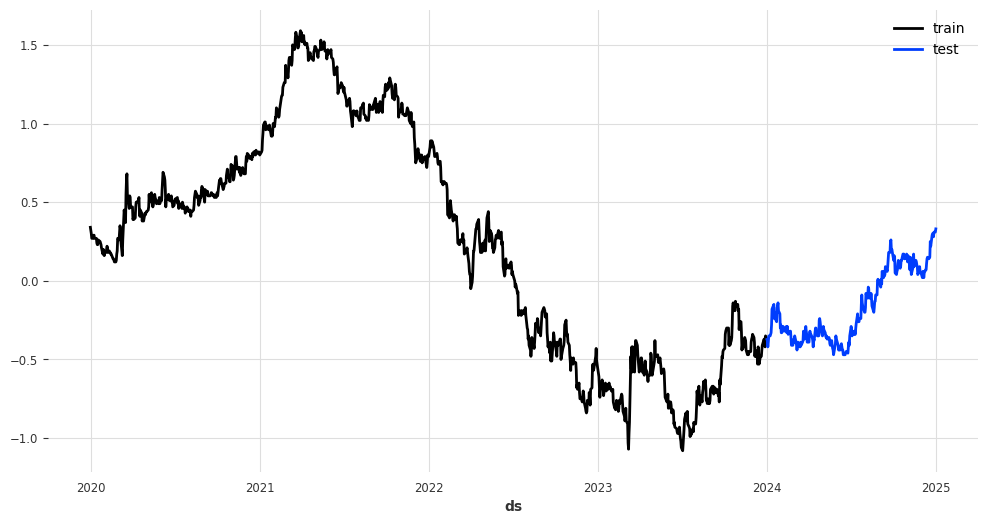

In [43]:
train, test = series.split_after(0.8)

plt.figure(figsize=(12, 6))
train.plot(label="train")
test.plot(label="test")
plt.legend()


In [44]:
from darts.models import Prophet

17:40:17 - cmdstanpy - INFO - Chain [1] start processing
17:40:17 - cmdstanpy - INFO - Chain [1] done processing


mse: 0.0271
mae: 0.1356


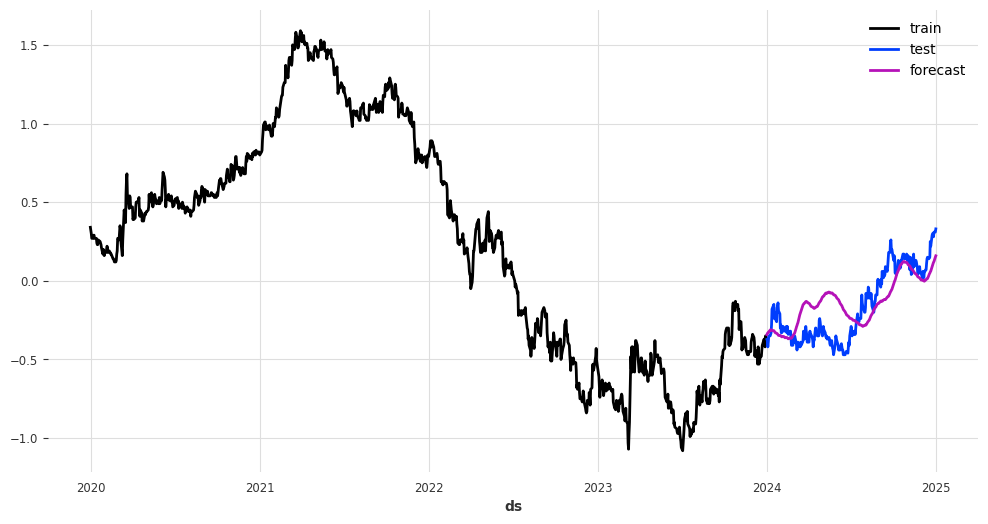

In [45]:
model = Prophet()
model.fit(train) 

forecast = model.predict(len(test))

print(f"mse: {mse(test, forecast):.4f}")
print(f"mae: {mae(test, forecast):.4f}")

plt.figure(figsize=(12, 6))
train.plot(label="train")
test.plot(label="test")
forecast.plot(label="forecast")
plt.legend()
plt.grid(True)
plt.show()

Отримали схожий результат, що і не дивно - ми використовували одну й ту саму модель. Але що важливо зауважити: darts самостійно правильно заповнив пропущєні значення, коли ми для Prophet заповнювали їх нулями. Також darts потребує в нашому випадку менше препроцессінга: нам не обов'язково було заповнювати відсутні дати, у випадку з prophet без заповнення відсутніх дат наш форкаст був невірним

# автокореляція та напівкореляція

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [47]:
# для Prophet та Darts не особо важлива стаціонарність ряду, так як вони враховують тренди та сезонність. 
# Але для перевірки на автокореляцію та кореляцію ми обов'язково маємо забезпечити стаціонарність ряду

result = adfuller(df_all_dates["y"])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Критичні значення:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

# adf ближче до нуля ніж усі критичні значення, що каже нам про нестаціонарність ряду 
# p-value > 0.5 (оберемо це значення, припустивши що хибнопозитивні результати для нас не є критичними ). 
# Тож у такому випадку ми не можемо відхилити нульову гіпотезу, що стверджує що ряд не є стаціонарним. 
# тож все каже про те що ряд не є стаціонарним, що не важливо у випадку використання Prophet, але при використанні Darts ми не можемо використовувати моделі ARIMA/SARIMA,
# не привевши ряд до стаціонарності


ADF Statistic: -0.9945837769350744
p-value: 0.7552346144110453
Критичні значення:
	1%: -3.4339461240890983
	5%: -2.8631284882870625
	10%: -2.5676156576381293


In [48]:
df_all_dates["y_diff"] = df_all_dates["y"].diff().fillna(0)
df_all_dates["y_diff"].isna().sum()

0

In [49]:

result = adfuller(df_all_dates["y_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# тепер бачимо що наш ряд стаціонарний. так як p-value дорівнює нулю - можемо вже сказати що ряд немає суттєвих патернів та залежностей

ADF Statistic: -19.20246152114486
p-value: 0.0


Index(['ds', 'y_diff'], dtype='object')


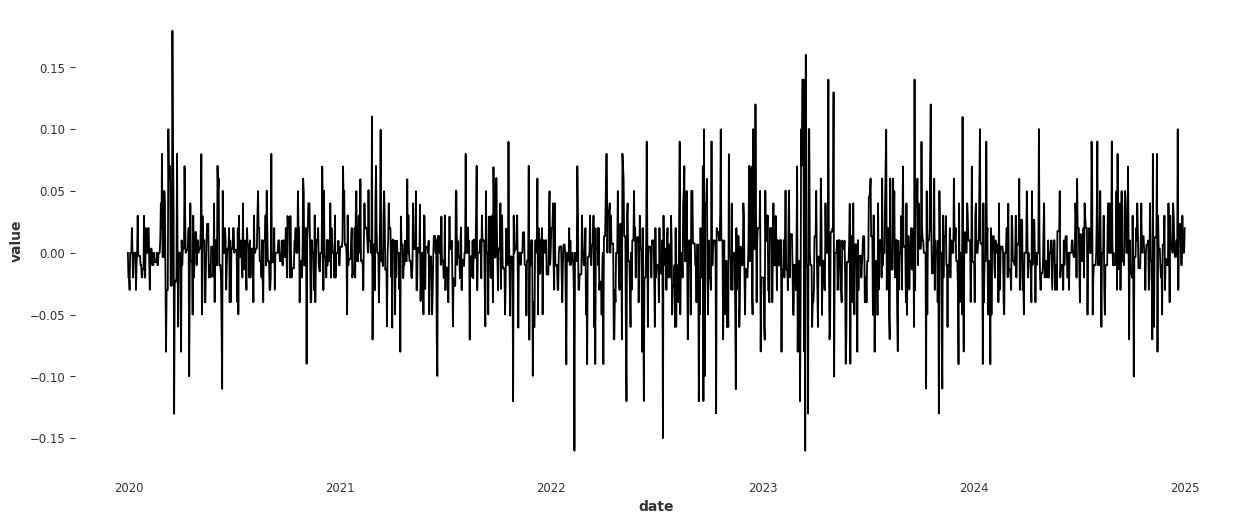

In [50]:
plot_df(df_all_dates.drop(columns="y"))

Text(0.5, 1.0, 'напівкореляція')

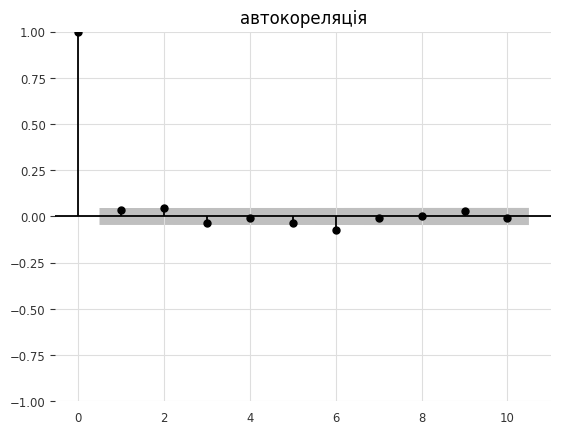

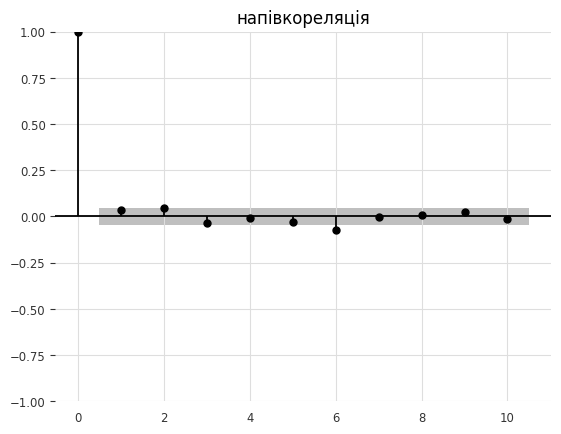

In [51]:

plot_acf(df_all_dates["y_diff"].dropna(), lags=10)
plt.title("автокореляція")

plot_pacf(df_all_dates["y_diff"].dropna(), lags=10)
plt.title("напівкореляція")


бачимо абсолютно ідентичні графіки, на яких елемент корелює тільки сам із собою, що підтверджує те що дані випадкові, не мають залежностей та патернів. Тільки лаг №6 трохи виходить за діапазон довіри. 